In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap

# Function definitions

In [2]:
def assess_on_val(clf, X_val_vectorized, y_val):
    print("Start predicting")
    predicted = clf.predict(X_val_vectorized)
    print("Finished predicting")
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in np.unique(y_val)}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)    
    fig.suptitle(str(clf._final_estimator), y=1.1)
    
    print("Global accuracy: " + str(total_accuracy))
    return fig


# Load saved data

In [3]:
os.getcwd()
os.chdir(r"D:\sep22_10_supply_chain\data")

In [4]:
data_en = pd.read_pickle(r"data_en2.pickle")

In [5]:
data_en.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,language,processed_reviews,lem_pos_ner_rem
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,EN,use elit danger mac amaz joystick especi love ...,use_VERB this_PRON for_ADP on_ADP my_PRON mac_...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,EN,love even realis game mous type silent mous se...,love_VERB it_PRON I_PRON do_AUX not_PART even_...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,EN,poor qualiti advertis,poor_ADJ quality_NOUN work_NOUN and_CCONJ not_...
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,EN,nice tend slip away stick intens hard press ga...,nice_ADJ but_CCONJ tend_VERB to_PART slip_VERB...
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,EN,great amiibo great collect qualiti materi desi...,great_ADJ amiibo_NOUN great_ADJ for_ADP collec...


# Undersampling to reduce calculation load and balance data

In [6]:
X = data_en["lem_pos_ner_rem"]#"processed_reviews"]
y = data_en["star_rating"]

In [7]:
rs = [resample(X[y == sr], y[y == sr], replace=False, n_samples=int(np.floor((X[y == 2].shape[0]))), random_state=123) for sr in [1,2,3,4,5]]


In [8]:
X_list = [rs[r][0] for r in range(5)]
y_list = [rs[r][1] for r in range(5)]

X_us = np.hstack(X_list)
y_us = np.hstack(y_list)



In [9]:
X_us.shape

(469605,)

# Split data into train, test and val

In [10]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

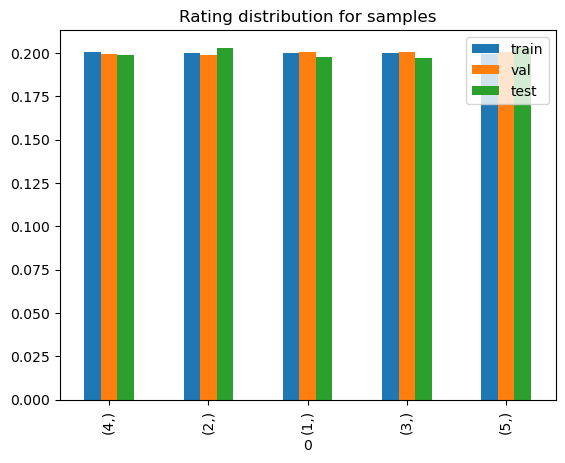

In [11]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples");


# Pipeline


In [14]:
def selpc_fun(X,y):
        f = X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

def selpc_fun_inv(X,y):
        f = -1.0*X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

# Parameters
lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
varth_params = dict(threshold=0.00005/100)
percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline



#clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=0.8,
#              colsample_bynode=1, colsample_bytree=0.9, eval_metric='mlogloss',
#              gamma=0, gpu_id=-1, importance_type='gain',
#              interaction_constraints='', learning_rate=0.05,
#              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
#              monotone_constraints='()', n_estimators=100, n_jobs=12,
#              num_parallel_tree=10, objective='multi:softprob', random_state=0,
# reg_alpha=0.3, reg_lambda=1, scale_pos_weight=None, subsample=1,
#              tree_method='exact', use_label_encoder=True,
#              validate_parameters=1, verbosity=None)



lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

#xgb_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
#        ("tfidf", TfidfTransformer(**tfidf_params)),
#        #("percth", SelectPercentile(**percth_params)),
#        #("varth", VarianceThreshold(**varth_params)),
#        ("clf", clf_xgb)]


pipeline = Pipeline(lr_steps)

pipeline.fit(X_train, y_train)
print("Training_Score: ", pipeline.score(X_train, y_train), " / Val. Score: ", pipeline.score(X_val, y_val))



Training_Score:  0.6106515049882348  / Val. Score:  0.5436077256691818


Start predicting
Finished predicting
Global accuracy: 0.5166275083226269


Predicted class,1,2,3,4,5
Actual class,,,,,
1,0.601835,0.217015,0.066664,0.024820,0.031271
2,0.230757,0.453117,0.232846,0.069150,0.039308
3,0.096532,0.235171,0.425192,0.221534,0.084110
4,0.037039,0.066338,0.209191,0.463655,0.247998
5,0.033836,0.028359,0.066106,0.220841,0.597312


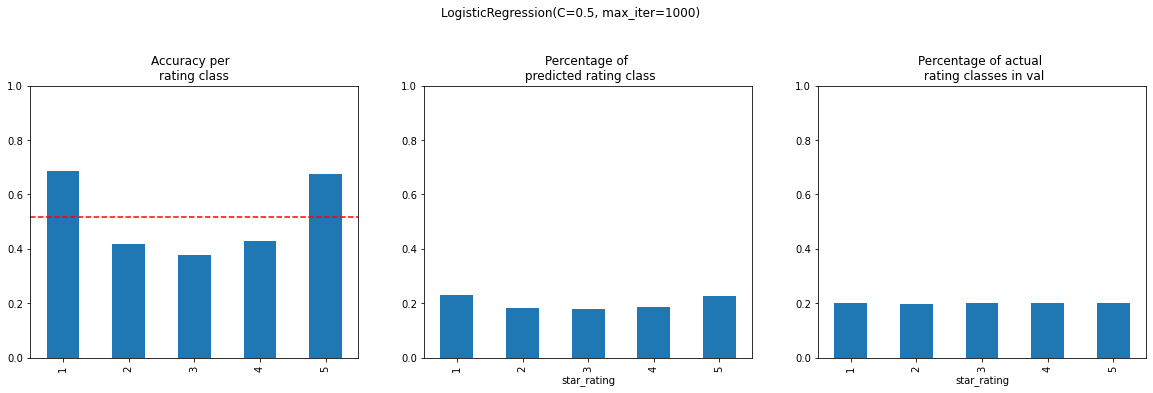

In [18]:
assess_on_val(pipeline, X_val, y_val);
confusion_matrix = pd.crosstab(y_val, pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
confusion_matrix

# SHAP interpretation

In [19]:
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
def f(X):    
    val = pipeline.predict(X)
    return val

In [20]:
masker = shap.maskers.Text(r"\W") # this will create a basic whitespace tokenizer
explainer = shap.Explainer(f, masker)#, output_names=labels)

In [24]:
true_pred= pd.DataFrame({"true": y_val, "pred": f(X_val)})

In [29]:
true_pred["delta"] = abs(true_pred.true -true_pred.pred)
true_pred.sort_values("delta", ascending=False).head(10)

,true,pred,delta
46253,5,1,4
123954,5,1,4
39657,5,1,4
84682,5,1,4
84669,5,1,4
26802,5,1,4
32899,1,5,4
39634,5,1,4
32903,1,5,4
84626,5,1,4


In [28]:
shap_values = explainer(X_val[true_pred.sort_values("delta", ascending=False).head(10).index])
shap.plots.text(shap_values)

# Recoding labels 

In [13]:
def recode_labels(in_array):
        rec = [0 if x in [1,2] else (1 if x ==3 else 2) for x in in_array]
        return(np.array(rec))
y_train_rec = recode_labels(y_train)

In [16]:
tes = pd.DataFrame({"rec": y_train_rec, "orig": y_train})
tes.head(20)

,rec,orig
0,0,2
1,0,2
2,1,3
3,1,3
4,0,2
5,0,1
6,0,1
7,0,2
8,2,5
9,1,3


In [27]:
# recode labels
def recode_labels(in_array):
        rec = [0 if x in [1,2] else (1 if x ==3 else 2) for x in in_array]
        return(np.array(rec))


lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
#varth_params = dict(threshold=0.00005/100)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline



lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lr_steps)

pipeline.fit(X_train, recode_labels(y_train))
print("Training_Score: ", pipeline.score(X_train, recode_labels(y_train)), " / Val. Score: ", pipeline.score(X_val, recode_labels(y_val)))


Training_Score:  0.7398140261215219  / Val. Score:  0.7109454855195911


Start predicting
Finished predicting
Global accuracy: 0.7109454855195911


Predicted class,0,1,2
Actual class,,,
0,0.723917,0.251207,0.096606
1,0.176592,0.500658,0.160091
2,0.099491,0.248135,0.743303


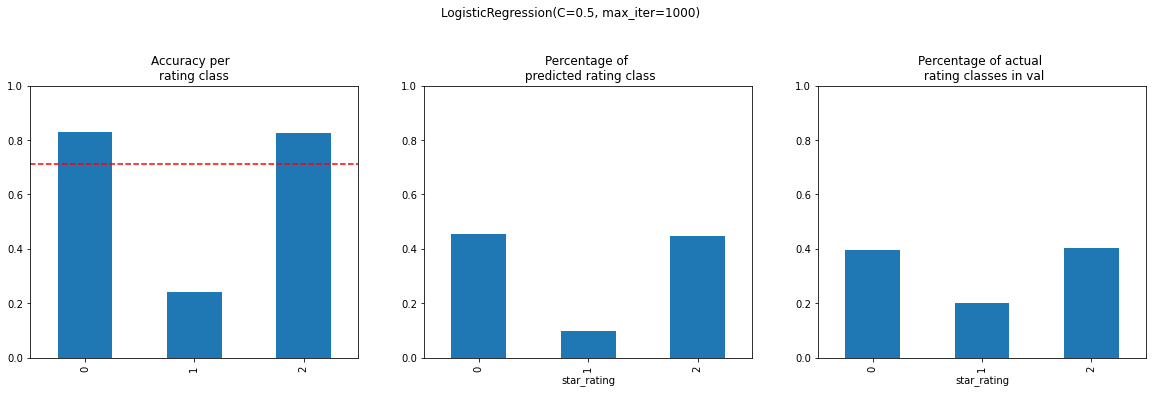

In [35]:
assess_on_val(pipeline, X_val, recode_labels(y_val));
confusion_matrix = pd.crosstab(recode_labels(y_val), pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
confusion_matrix

In [34]:
pd.DataFrame(recode_labels(pipeline.predict(X_val))).value_counts()

0    38417
2    32023
dtype: int64

In [ ]:
pd.DataFrame(pipeline.predict(X_val)).value_counts()

In [12]:
#from gensim.models import Word2Vec
from gensim.sklearn_api import W2VTransformer

In [13]:
lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
word2vec_params = dict(min_count=1, window = 5)
#varth_params = dict(threshold=0.00005/100)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline



lrw2v_steps = [ ("vect", W2VTransformer(**word2vec_params)),
        #("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lrw2v_steps)

pipeline.fit(X_train, y_train)

KeyError: "word 'got game christma gift much anticip great workout huge ufc fan workout time natur thought would great option unfortun think far mani break move far slow like hard break sweat realli friend let play kinda thing ask fun challeng workout slightest' not in vocabulary"

# RandomsearchCV

In [100]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0,0.005,0.01,0.025, 0.05,0.1],
    'vect__max_df' : [0.3, 0.35,0.5,0.75,0.9],    
}


random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=4, 
            n_iter=15,
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True,
            random_state=42)



random_cv.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(max_df=0.35,
                                                              min_df=0.001,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf',
                                              LogisticRegression(C=0.5,
                                                                 max_iter=1000))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
                                                   0.5, 0.75, 1],
                                        'vect__max_df': [0.3, 0.35, 0.5, 0.75,
                                                         0.9]

In [101]:
best_pipe = random_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect', CountVectorizer(max_df=0.9, min_df=0)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.3, max_iter=1000))])

In [102]:
best_pipe.score(X_val, y_val)

0.497671777399205

Start predicting
Finished predicting
Global accuracy: 0.497671777399205


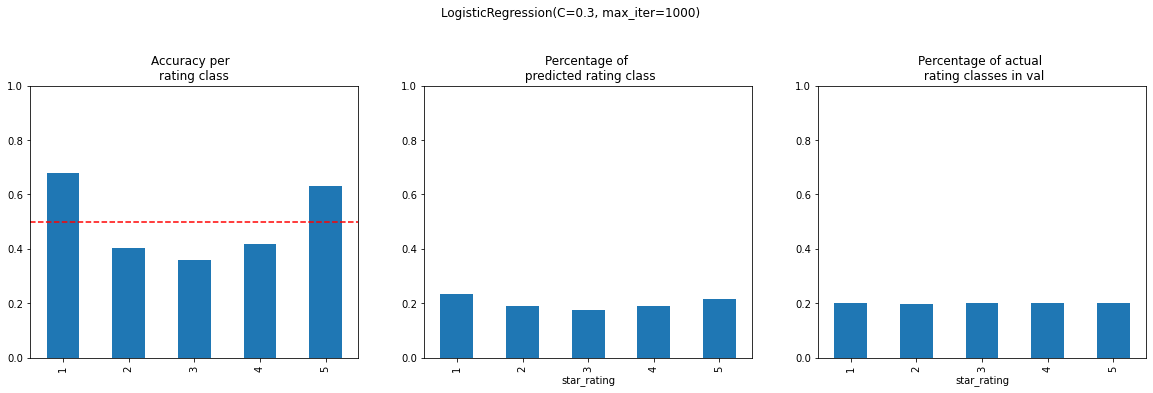

In [103]:
assess_on_val(best_pipe, X_val, y_val);

# Gridsearch

In [128]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    #'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0.001],
    'vect__max_df' : [0.35],    
}


grid_cv = GridSearchCV(estimator=pipeline,
            param_grid=hyperparameter_grid,
            cv=4,             
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True)



grid_cv.fit(X_train, y_train)
best_pipe = grid_cv.best_estimator_
best_pipe


Fitting 4 folds for each of 8 candidates, totalling 32 fits


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.35, min_df=0.001,
                                 ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.3, max_iter=1000))])

0.13508517176729928

In [129]:
best_pipe.score(X_val, y_val)

0.5102924474730267

Start predicting
Finished predicting
Global accuracy: 0.5102924474730267


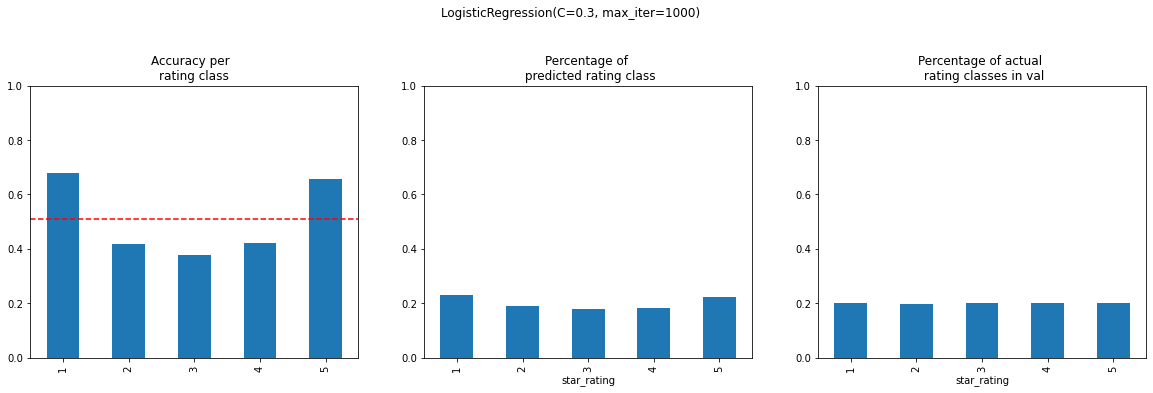

In [130]:
assess_on_val(best_pipe, X_val, y_val);

In [ ]:
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                                  criterion=criterion,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  random_state=42)
    score =  cross_val_score(estimator=rfc, 
                             X=X_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5,
                             n_jobs=-1).mean()
    
    return score

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=100)
time_bayesian = time.time() - time_start

# store result in a data frame 
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights)

    # SW
    lr_params = dict(C=0.5, max_iter=1000)
    vectorizer_params = dict(ngram_range=(1, 3), min_df=0.00, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
    tfidf_params = dict(norm='l2')
    varth_params = dict(threshold=0.00005/100)
    percth_params = dict(score_func= selpc_fun, percentile = 95)
    # Supervised Pipeline




    lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
            ("tfidf", TfidfTransformer(**tfidf_params)),
            #("percth", SelectPercentile(**percth_params)),
            #("varth", VarianceThreshold(**varth_params)),
            ("clf", LogisticRegression(**lr_params))]

    pipeline = Pipeline(lr_steps)

    #SW
    
    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1')
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

In [95]:
pd.DataFrame(pipeline.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,vect
4,tfidf
5,clf
6,vect__analyzer
7,vect__binary
8,vect__decode_error
9,vect__dtype


In [71]:
pd.DataFrame.from_dict(lr_pipeline.steps[0][1].vocabulary_, orient="index").reset_index().sort_values(by=0)

,index,0
2207,aa,0
1219,aaa,1
343,abandon,2
1635,abil,3
44,abl,4
...,...,...
2095,zip,3411
770,zombi,3412
2235,zone,3413
2326,zoom,3414


In [99]:
dict(zip(feature_names.ravel() , X_train_vectorized.mean(axis=1))) 
#stopwrods: xbox, nintendo, game, amazon, christma, gamecub, im, mario, around, basketbal

{'aa': matrix([[0.00034342]]),
 'aaa': matrix([[0.00059032]]),
 'ab': matrix([[0.00056063]]),
 'abacus': matrix([[0.00032889]]),
 'abandon': matrix([[0.00041731]]),
 'abba': matrix([[0.00022538]]),
 'abc': matrix([[0.00030099]]),
 'abd': matrix([[0.0004535]]),
 'abe': matrix([[0.00020932]]),
 'abil': matrix([[0.00026331]]),
 'abilit': matrix([[0.00029385]]),
 'abit': matrix([[0.00039747]]),
 'abl': matrix([[0.00049444]]),
 'abnorm': matrix([[0.00059856]]),
 'abomin': matrix([[0.00100907]]),
 'abort': matrix([[0.00063437]]),
 'abound': matrix([[0.00019273]]),
 'abras': matrix([[0.00037401]]),
 'abroad': matrix([[0.0004026]]),
 'abrupt': matrix([[0.00032712]]),
 'absenc': matrix([[0.00089944]]),
 'absent': matrix([[0.00090666]]),
 'absolut': matrix([[0.00101455]]),
 'absolutley': matrix([[0.00020835]]),
 'absorb': matrix([[0.00046401]]),
 'abstract': matrix([[0.00028085]]),
 'absurd': matrix([[0.00121324]]),
 'abt': matrix([[0.00052331]]),
 'abund': matrix([[0.00038551]]),
 'abus': matri

# Classification

In [46]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)
clf_knn = KNeighborsClassifier(n_neighbors=40).fit(X_train_vectorized, y_train)
clf_lr = LogisticRegression(max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L2_05 = LogisticRegression( C=0.5,max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L1_05 = LogisticRegression(penalty="l1", C=0.25,max_iter=1000, solver= "saga").fit(X_train_vectorized, y_train)
clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5,
              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)



# Appendix

In [45]:
# Assessement of results
# Add vine flag as feature!

In [35]:





#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

Start predicting
Finished predicting
Global accuracy: 0.4617830777967064


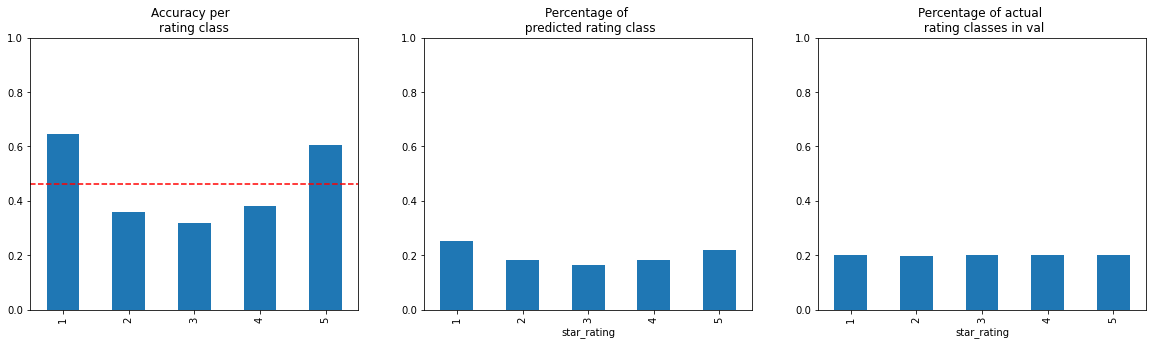

In [47]:

assess_on_val(clf_mnNB, X_val_vectorized, y_val);



Start predicting
Finished predicting
Global accuracy: 0.49646507666098805


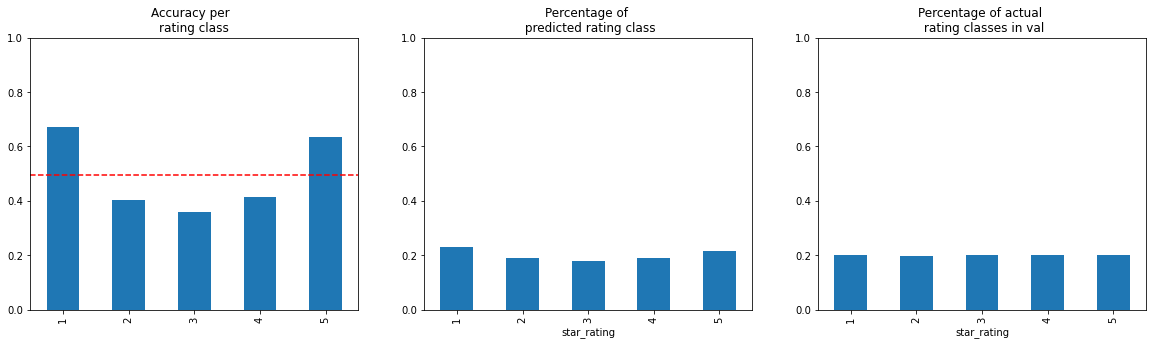

In [36]:
# New sample
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

In [46]:
clf_lr_L2_05.score(X_val_vectorized, y_val)

0.49646507666098805

Start predicting
Finished predicting
Global accuracy: 0.5043441226575809


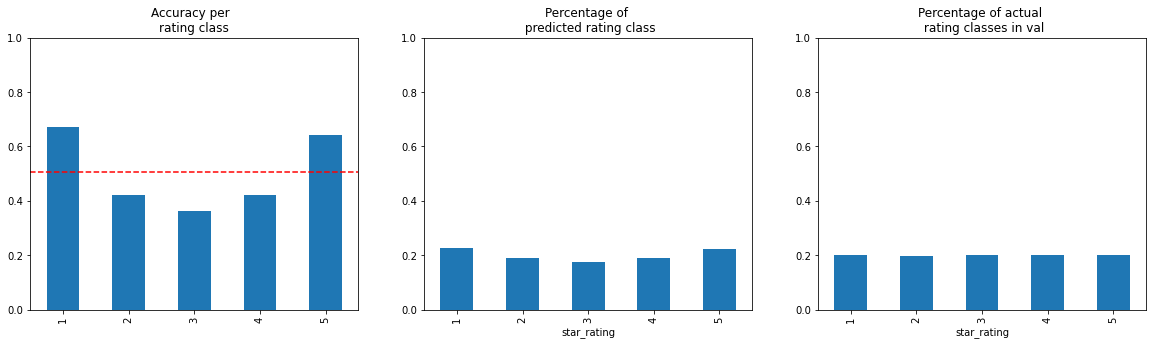

In [106]:
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

Start predicting
Finished predicting
Global accuracy: 0.49622373651334467


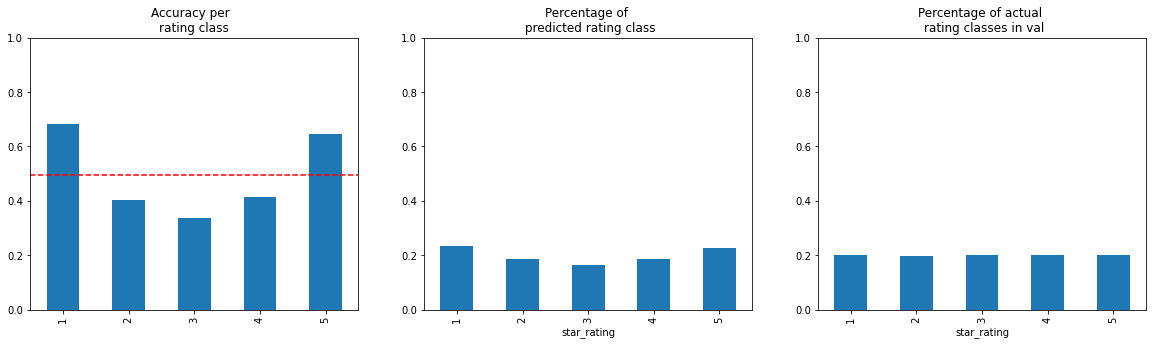

In [105]:
assess_on_val(clf_lr_L1_05, X_val_vectorized, y_val);

In [95]:
#Analyse words predicting class 0
coefs = pd.DataFrame.from_dict({"coef": clf_lr_L2_05.coef_[0,:], "feature": feature_names.ravel()}, orient="index")
coefs = coefs.transpose()
coefs["abs_coef"]=np.abs(coefs.coef)
coefs.sort_values(by="abs_coef", ascending=False).head(40)

,coef,feature,abs_coef
2663,-6.34947,great,6.34947
6921,6.003601,worst,6.003601
6764,5.691694,wast,5.691694
6136,5.129915,terribl,5.129915
3605,-4.973701,love,4.973701
2931,4.359777,horribl,4.359777
5092,4.23451,return,4.23451
1609,4.134234,disappoint,4.134234
4424,-4.101356,perfect,4.101356
2479,4.002121,garbag,4.002121


,coef,feature
1069,-6.373212,great
1416,-5.001928,love
1748,-4.128307,perfect
221,-4.0107,best
990,-3.869566,fun
...,...,...
2014,4.254924,return
1172,4.397509,horribl
2430,5.17903,terribl
2661,5.757634,wast


Start predicting
Finished predicting
Global accuracy: 0.5320414537194775


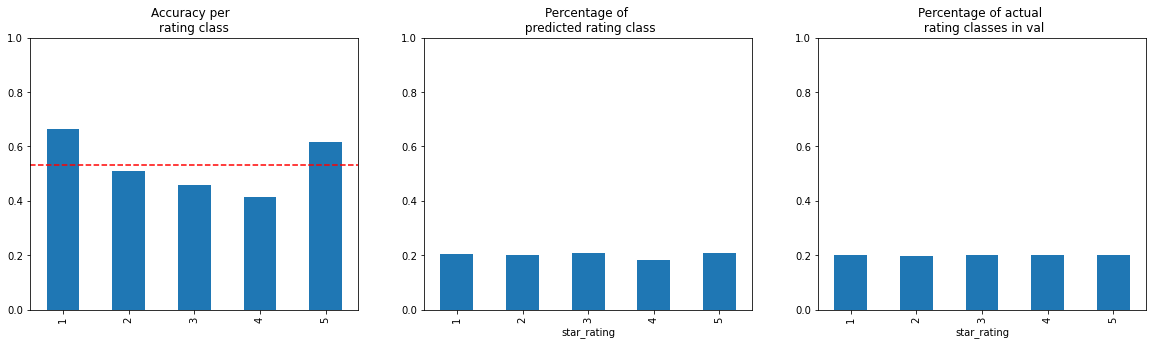

In [109]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
# 10000 features (/10 for variance threshold)

Start predicting
Finished predicting
Global accuracy: 0.5330777967064169


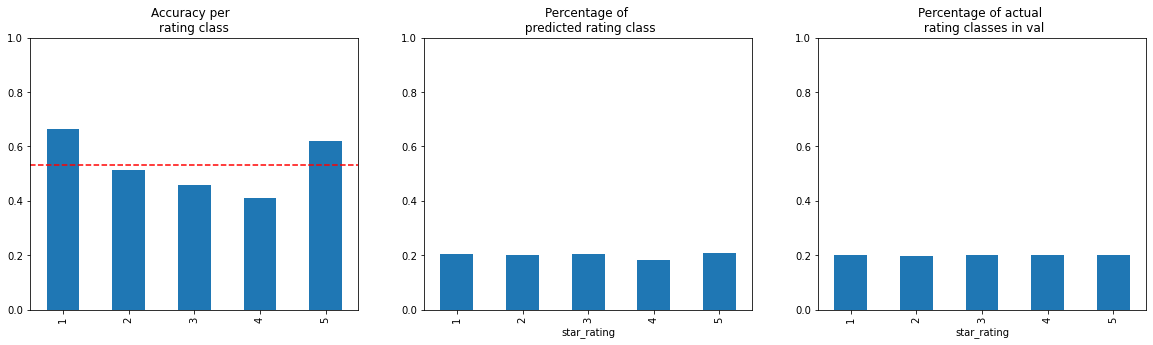

In [114]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#/2 => 4000 features

Start predicting
Finished predicting
Global accuracy: 0.5342703009653605


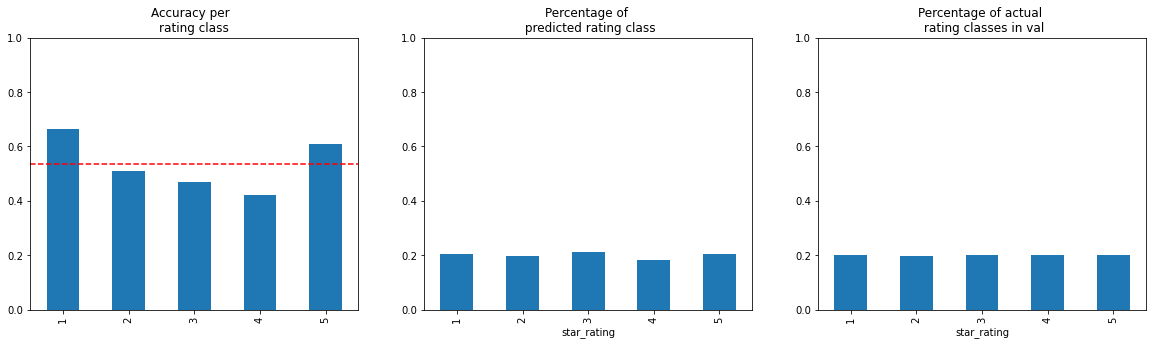

In [121]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#1 

In [46]:
import joblib
joblib.dump(clf_knn, "knn_model_dump.sav")

['knn_model_dump.sav']

In [47]:
os.getcwd()

'D:\\sep22_10_supply_chain\\data'